# Check NOAA CDR / Snow CCI period difference impact
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load observations

### Topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

In [4]:
ds = xr.open_dataset('/data/mlalande/Relief/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation_HR = ds.elevation

### Snow Cover

In [52]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

obs_ac = u.annual_cycle(obs, calendar='standard')
obs_ac_1982 = u.annual_cycle(obs.sel(time=slice('1982','2014')), calendar='standard')

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [53]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_regrid = regridder(obs)

Reuse existing file: bilinear_88x88_35x60.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [54]:
import scipy

def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc = xr.concat(temp, pd.Index(zones, name="zone")).load()


# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_1982_regrid = regridder(obs_ac_1982)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_1982_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones_snc_1982 = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_88x88_35x60.nc


## ESA snow CCI
We keep it at its original resolution because of NaNs values and use higher resolution topography to define the zones.

In [32]:
path = '/data/mlalande/ESACCI/ESA_CCI_snow_SCFG_v1.0_HKH_gapfilled_monthly'
esa_snc_icefilled = xr.open_dataarray(path+'/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_icefilled_montlhy_1982-2014.nc')
regridder = xe.Regridder(elevation_HR, esa_snc_icefilled, 'bilinear', periodic=False, reuse_weights=True)
elevation_HR_regrid = regridder(elevation_HR)

temp = [None]*len(zones)
esa_snc_ac_icefilled = esa_snc_icefilled.groupby('time.month').mean('time') # otherwise bug with u.annual_cycle (0 on glaciers instead of nan)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        esa_snc_ac_icefilled.sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim[zone]).where(elevation_HR_regrid > 2500)
    )

esa_snc_ac_icefilled_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_560x960_500x920.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Check timeseries

In [37]:
obs_regrid_ts = (u.spatial_average(obs_regrid.resample(time='A').mean('time').sel(lat=zones_df.latlim['HMA'], lon=zones_df.lonlim['HMA']).where(elevation > 2500)))
esa_snc_icefilled_ts = (u.spatial_average(esa_snc_icefilled.resample(time='A').mean('time').sel(lat=slice(zones_df.latlim[zone].stop, zones_df.latlim[zone].start), lon=zones_df.lonlim['HMA']).where(elevation_HR_regrid > 2500)))

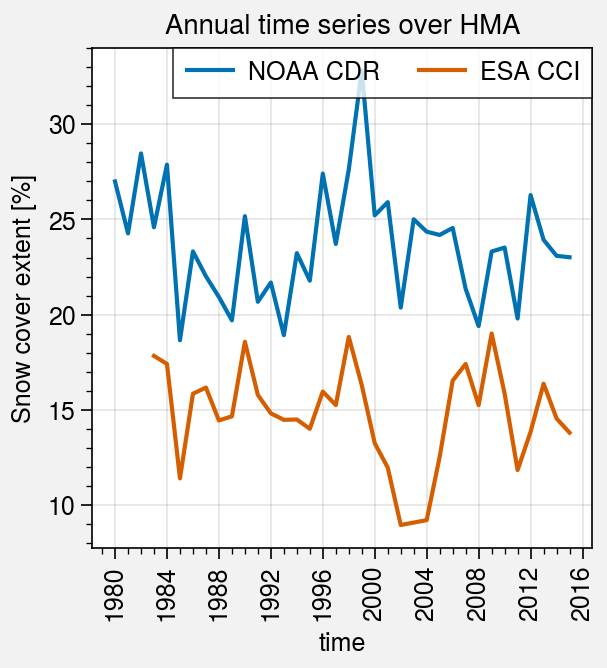

In [46]:
fig, axs = plot.subplots()

axs[0].plot(obs_regrid_ts, label='NOAA CDR')
axs[0].plot(esa_snc_icefilled_ts, label='ESA CCI')

axs[0].legend()

axs[0].format(
    ylabel='Snow cover extent [%]',
    title='Annual time series over HMA'
)

fig.save('img/snc_ann_ts_noaa-cci.jpg')

## Plot

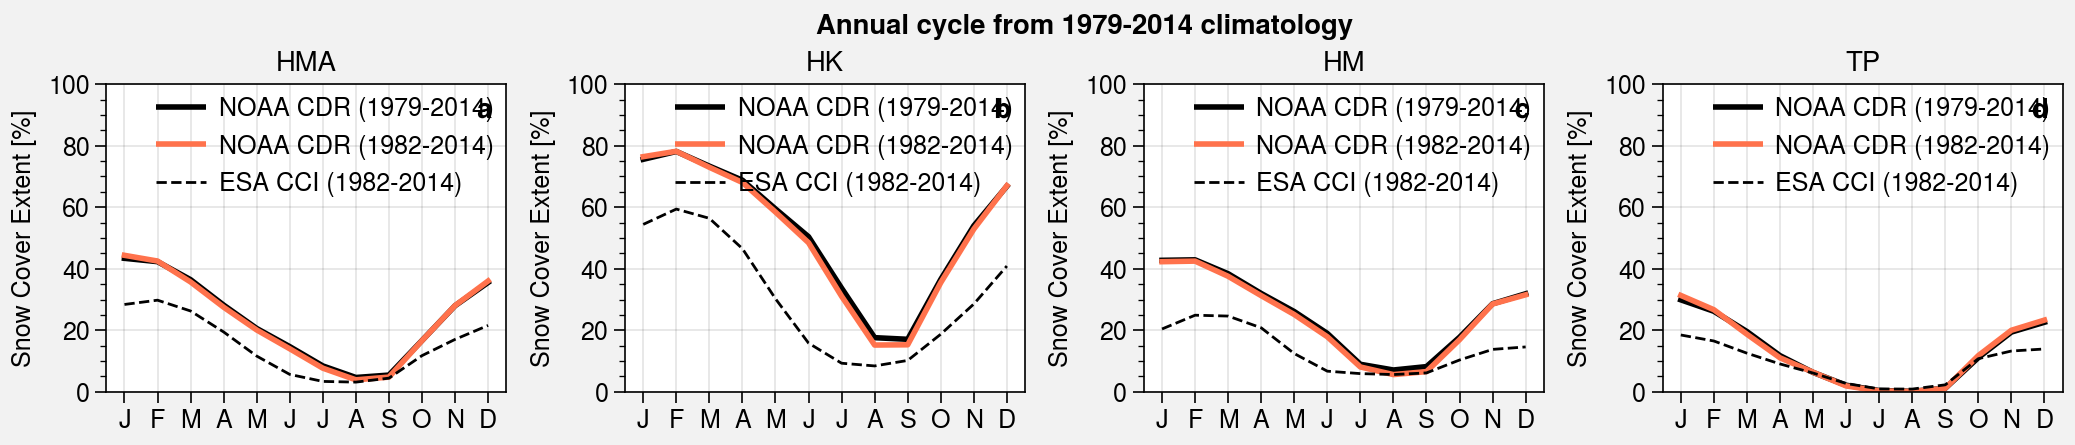

In [56]:
f, axs = plot.subplots(ncols=4, nrows=1, aspect=1.3, sharey=0, axwidth=2)

color_model = 'ocean blue'
color_obs = 'black'
color_era = 'pink orange'

n_ax = 0
for i_var, var in enumerate(['snc']):
    for i in range(len(zones)):

        # Plot observations
        h1 = axs[n_ax].plot(obs_ac_regrid_zones_snc[i], label='NOAA CDR (1979-2014)', color=color_obs, linewidth=2)
        h2 = axs[n_ax].plot(obs_ac_regrid_zones_snc_1982[i], label='NOAA CDR (1982-2014)', color=color_era, linewidth=2)
        h3 = axs[n_ax].plot(esa_snc_ac_icefilled_zones[i], label='ESA CCI (1982-2014)', color=color_obs, linewidth=1, linestyle='--')
        
        axs[n_ax].format( 
            ylim=(0, 100),
            xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
            xlabel=''
        )
  
        
        axs[n_ax].format(title=zones[n_ax])

        h = [h1, h2, h3]
        loc = 'ur'

        axs[n_ax].legend(h, loc=loc, frame=False, ncols=1)

        labels=['Snow Cover Extent [%]']
        axs[n_ax].format( 
            ylabel = labels[i_var]
        )
        
        n_ax += 1

axs.format(
    suptitle='Annual cycle from '+period.start+'-'+period.stop+' climatology',
#     collabels=zones,
    abc=True, abcloc='ur'
)
    
filename = 'fig5_ac_snc_check_period'
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')